In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import pacf
import datetime
%matplotlib inline
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop, Adam,SGD

In [2]:
def plot_series(df,format='-',start = 0, end = None):
    plt.plot(df['Umsatz'],format)
    plt.xlabel("Time")
    plt.ylabel("sales")
    plt.grid(True)

In [3]:
dataframe = pd.read_csv('meteolytix_Corona_bakery_turnover_updated.csv')

dataframe['Datum']=pd.to_datetime(dataframe['Datum'])

dataframe['Quarter'] = dataframe['Datum'].apply(lambda x: x.quarter)
dataframe['DayofTheWeek'] = dataframe['Datum'].apply(lambda x: x.weekday()+1)


In [4]:
cdf = pd.read_csv('covid-data.csv')
cdf['date'] = pd.to_datetime(cdf['date'])

cdf.rename(columns={'date':'Datum'},inplace=True)

cdf = cdf[['Datum','total_cases','new_cases','total_cases_per_million','new_cases_per_million']]

In [5]:
dataframe = dataframe.join(cdf.set_index('Datum'),on='Datum')

In [6]:
dataframe[['total_cases','new_cases','total_cases_per_million','new_cases_per_million']]= dataframe[['total_cases','new_cases','total_cases_per_million','new_cases_per_million']].fillna(0)

In [7]:
prodG3 = dataframe[dataframe['Warengruppe'] == 3]

In [8]:
prodG3.drop('Warengruppe',axis=1,inplace=True) 

In [9]:
prodG3.set_index('Datum',inplace=True)

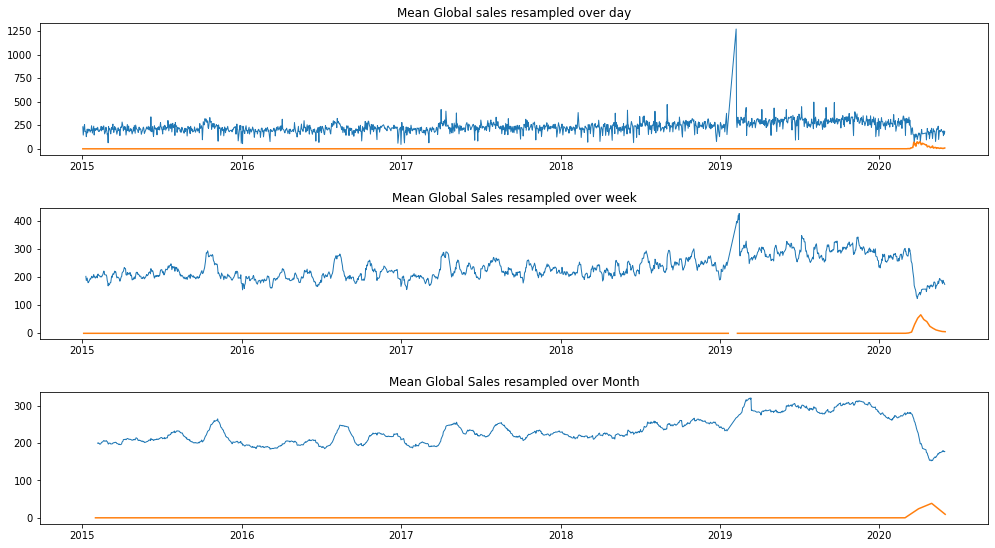

In [10]:
fig = plt.figure(figsize=(17,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(prodG3['Umsatz'].rolling(window=1).mean(),linewidth=1)
ax1.set_title('Mean Global sales resampled over day')
ax1.tick_params(axis='both', which='major')
ax1.plot(prodG3['new_cases_per_million'])

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(prodG3['Umsatz'].rolling(window=7).mean(),linewidth=1)
ax2.set_title('Mean Global Sales resampled over week')
ax2.tick_params(axis='both', which='major')
ax2.plot(prodG3['new_cases_per_million'].resample('W').mean())

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(prodG3['Umsatz'].rolling(window=30).mean(),linewidth=1)
ax3.set_title('Mean Global Sales resampled over Month')
ax3.tick_params(axis='both', which='major')
ax3.plot(prodG3['new_cases_per_million'].resample('M').mean())


In [11]:
meanprodG3 = prodG3
meanprodG3['Umsatz'] = meanprodG3['Umsatz'].rolling(window=14).mean()
meanprodG3['Umsatz'] = meanprodG3['Umsatz'].fillna(0)
meanprodG3.reset_index(inplace=True)
meanprodG3.head()

,Datum,Umsatz,Quarter,DayofTheWeek,total_cases,new_cases,total_cases_per_million,new_cases_per_million
0,2015-01-02,0.0,1,5,0.0,0.0,0.0,0.0
1,2015-01-03,0.0,1,6,0.0,0.0,0.0,0.0
2,2015-01-05,0.0,1,1,0.0,0.0,0.0,0.0
3,2015-01-06,0.0,1,2,0.0,0.0,0.0,0.0
4,2015-01-07,0.0,1,3,0.0,0.0,0.0,0.0


In [12]:
    dataset = meanprodG3.Umsatz.values 
    dataset = dataset.astype('float32')
    dataset = np.reshape(dataset, (-1, 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    train_size = 1300
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [13]:
def create_dataset(dataset, window_size):
    X, Y = [], []
    for i in range(len(dataset)-window_size-1):
        a = dataset[i:(i+window_size), 0]
        X.append(a)
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)

In [14]:
window_size = 14
X_train, Y_train = create_dataset(train, window_size)
X_test, Y_test = create_dataset(test, window_size)

In [15]:
X_train.shape


(1285, 14)

In [16]:
Y_test.shape

(347,)

In [17]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [18]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, 
                         kernel_size=5,
                         strides=1,
                         padding="causal",
                         activation='relu',
                         input_shape=(X_train.shape[1], X_train.shape[2])),
  tf.keras.layers.LSTM(50,return_sequences=True),
  tf.keras.layers.LSTM(50),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

model.summary()

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-8)
model.compile(loss='mse',
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(X_train, Y_train, epochs=100,callbacks=[lr_schedule])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 32)             2272      
_________________________________________________________________
lstm (LSTM)                  (None, 1, 50)             16600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 128)               6528      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0

1285/1285 [==============================] - 0s 186us/sample - loss: 0.0144 - mae: 0.0932
Epoch 68/100
1285/1285 [==============================] - 0s 184us/sample - loss: 0.0116 - mae: 0.0822
Epoch 69/100
1285/1285 [==============================] - 0s 181us/sample - loss: 0.0102 - mae: 0.0748
Epoch 70/100
1285/1285 [==============================] - 0s 178us/sample - loss: 0.0076 - mae: 0.0658
Epoch 71/100
1285/1285 [==============================] - 0s 179us/sample - loss: 0.0061 - mae: 0.0590
Epoch 72/100
1285/1285 [==============================] - 0s 179us/sample - loss: 0.0049 - mae: 0.0527
Epoch 73/100
1285/1285 [==============================] - 0s 177us/sample - loss: 0.0046 - mae: 0.0500
Epoch 74/100
1285/1285 [==============================] - 0s 179us/sample - loss: 0.0039 - mae: 0.0453
Epoch 75/100
1285/1285 [==============================] - 0s 183us/sample - loss: 0.0030 - mae: 0.0404
Epoch 76/100
1285/1285 [==============================] - 0s 181us/sample - loss: 0.00

(1e-08, 0.1, 0.0001, 0.002)

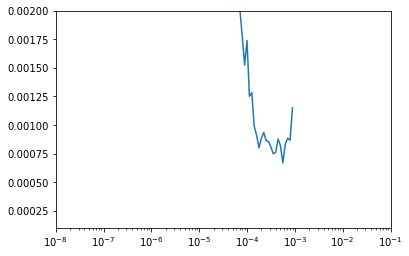

In [19]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-1, 0.0001, 0.002])

In [135]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, 
                         kernel_size=5,
                         strides=1,
                         padding="causal",
                         activation='relu',
                         input_shape=(X_train.shape[1], X_train.shape[2])),
  tf.keras.layers.LSTM(50,return_sequences=True),
  tf.keras.layers.LSTM(50),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

#model.summary()

model.compile(loss='mse',
                  optimizer=Adam(lr = 1e-5),
                  metrics=["mae"]
                  )


history = model.fit(X_train, Y_train, epochs=300, batch_size=30, validation_data=(X_test, Y_test), 
                     verbose=2, shuffle=False)


Train on 1285 samples, validate on 347 samples
Epoch 1/300
1285/1285 - 4s - loss: 4.2433 - mae: 2.0001 - val_loss: 3.2411 - val_mae: 1.7410
Epoch 2/300
1285/1285 - 0s - loss: 0.5956 - mae: 0.6884 - val_loss: 0.7803 - val_mae: 0.8375
Epoch 3/300
1285/1285 - 0s - loss: 0.1545 - mae: 0.2948 - val_loss: 0.3871 - val_mae: 0.6026
Epoch 4/300
1285/1285 - 0s - loss: 0.1277 - mae: 0.2715 - val_loss: 0.3320 - val_mae: 0.5587
Epoch 5/300
1285/1285 - 0s - loss: 0.1300 - mae: 0.2791 - val_loss: 0.3273 - val_mae: 0.5548
Epoch 6/300
1285/1285 - 0s - loss: 0.1234 - mae: 0.2727 - val_loss: 0.3076 - val_mae: 0.5379
Epoch 7/300
1285/1285 - 0s - loss: 0.1210 - mae: 0.2751 - val_loss: 0.2957 - val_mae: 0.5274
Epoch 8/300
1285/1285 - 0s - loss: 0.1200 - mae: 0.2730 - val_loss: 0.2983 - val_mae: 0.5296
Epoch 9/300
1285/1285 - 0s - loss: 0.1169 - mae: 0.2685 - val_loss: 0.2778 - val_mae: 0.5107
Epoch 10/300
1285/1285 - 0s - loss: 0.1068 - mae: 0.2595 - val_loss: 0.2749 - val_mae: 0.5078
Epoch 11/300
1285/1285

Epoch 88/300
1285/1285 - 0s - loss: 0.0025 - mae: 0.0358 - val_loss: 0.0015 - val_mae: 0.0295
Epoch 89/300
1285/1285 - 0s - loss: 0.0026 - mae: 0.0368 - val_loss: 0.0015 - val_mae: 0.0294
Epoch 90/300
1285/1285 - 0s - loss: 0.0023 - mae: 0.0355 - val_loss: 0.0013 - val_mae: 0.0271
Epoch 91/300
1285/1285 - 0s - loss: 0.0023 - mae: 0.0357 - val_loss: 0.0015 - val_mae: 0.0300
Epoch 92/300
1285/1285 - 0s - loss: 0.0023 - mae: 0.0340 - val_loss: 0.0014 - val_mae: 0.0281
Epoch 93/300
1285/1285 - 0s - loss: 0.0020 - mae: 0.0332 - val_loss: 0.0013 - val_mae: 0.0276
Epoch 94/300
1285/1285 - 0s - loss: 0.0020 - mae: 0.0330 - val_loss: 0.0014 - val_mae: 0.0288
Epoch 95/300
1285/1285 - 0s - loss: 0.0020 - mae: 0.0328 - val_loss: 0.0015 - val_mae: 0.0308
Epoch 96/300
1285/1285 - 0s - loss: 0.0018 - mae: 0.0310 - val_loss: 0.0011 - val_mae: 0.0249
Epoch 97/300
1285/1285 - 0s - loss: 0.0021 - mae: 0.0322 - val_loss: 0.0015 - val_mae: 0.0310
Epoch 98/300
1285/1285 - 0s - loss: 0.0018 - mae: 0.0309 - v

Epoch 172/300
1285/1285 - 0s - loss: 6.3547e-04 - mae: 0.0183 - val_loss: 0.0016 - val_mae: 0.0286
Epoch 173/300
1285/1285 - 0s - loss: 6.4048e-04 - mae: 0.0179 - val_loss: 0.0014 - val_mae: 0.0263
Epoch 174/300
1285/1285 - 0s - loss: 6.0152e-04 - mae: 0.0182 - val_loss: 0.0015 - val_mae: 0.0275
Epoch 175/300
1285/1285 - 0s - loss: 5.7145e-04 - mae: 0.0174 - val_loss: 0.0015 - val_mae: 0.0287
Epoch 176/300
1285/1285 - 0s - loss: 6.5353e-04 - mae: 0.0183 - val_loss: 0.0015 - val_mae: 0.0269
Epoch 177/300
1285/1285 - 0s - loss: 6.0345e-04 - mae: 0.0182 - val_loss: 0.0016 - val_mae: 0.0308
Epoch 178/300
1285/1285 - 0s - loss: 6.2277e-04 - mae: 0.0183 - val_loss: 0.0014 - val_mae: 0.0253
Epoch 179/300
1285/1285 - 0s - loss: 5.5508e-04 - mae: 0.0173 - val_loss: 0.0015 - val_mae: 0.0271
Epoch 180/300
1285/1285 - 0s - loss: 6.0519e-04 - mae: 0.0177 - val_loss: 0.0014 - val_mae: 0.0260
Epoch 181/300
1285/1285 - 0s - loss: 5.9870e-04 - mae: 0.0180 - val_loss: 0.0014 - val_mae: 0.0246
Epoch 182/

Epoch 255/300
1285/1285 - 0s - loss: 5.5045e-04 - mae: 0.0171 - val_loss: 0.0013 - val_mae: 0.0231
Epoch 256/300
1285/1285 - 0s - loss: 4.9799e-04 - mae: 0.0161 - val_loss: 0.0014 - val_mae: 0.0239
Epoch 257/300
1285/1285 - 0s - loss: 5.0622e-04 - mae: 0.0162 - val_loss: 0.0013 - val_mae: 0.0231
Epoch 258/300
1285/1285 - 0s - loss: 4.9999e-04 - mae: 0.0166 - val_loss: 0.0013 - val_mae: 0.0252
Epoch 259/300
1285/1285 - 0s - loss: 4.6041e-04 - mae: 0.0156 - val_loss: 0.0012 - val_mae: 0.0229
Epoch 260/300
1285/1285 - 0s - loss: 4.5381e-04 - mae: 0.0157 - val_loss: 0.0013 - val_mae: 0.0238
Epoch 261/300
1285/1285 - 0s - loss: 4.7539e-04 - mae: 0.0160 - val_loss: 0.0013 - val_mae: 0.0233
Epoch 262/300
1285/1285 - 0s - loss: 4.6425e-04 - mae: 0.0155 - val_loss: 0.0012 - val_mae: 0.0241
Epoch 263/300
1285/1285 - 0s - loss: 5.4732e-04 - mae: 0.0167 - val_loss: 0.0013 - val_mae: 0.0241
Epoch 264/300
1285/1285 - 0s - loss: 4.8103e-04 - mae: 0.0161 - val_loss: 0.0013 - val_mae: 0.0243
Epoch 265/

In [136]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train_Sca = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test_Sca = scaler.inverse_transform([Y_test])



In [137]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train_Sca[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train_Sca[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test_Sca[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test_Sca[0], test_predict[:,0])))

Train Mean Absolute Error: 4.753046842327096
Train Root Mean Squared Error: 6.420836634640767
Test Mean Absolute Error: 8.62080064255898
Test Root Mean Squared Error: 12.733364690703297


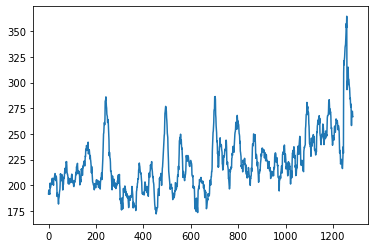

In [138]:
plt.plot(Y_train_Sca[0])

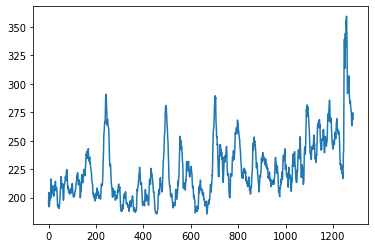

In [139]:
plt.plot(train_predict[:,0])

In [140]:
train_predict[:,0]

array([194.22357, 204.53098, 191.82516, ..., 268.9714 , 274.40854,
       268.92322], dtype=float32)

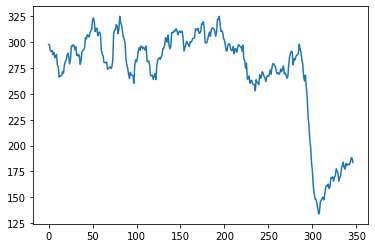

In [141]:
plt.plot(Y_test_Sca[0])

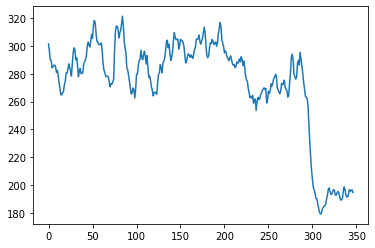

In [142]:
plt.plot(test_predict[:,0])

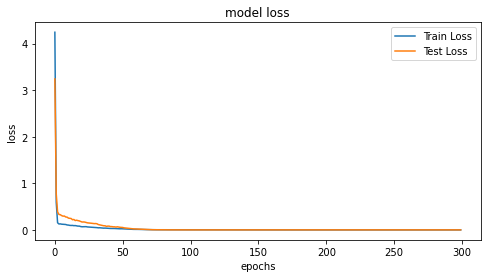

In [143]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

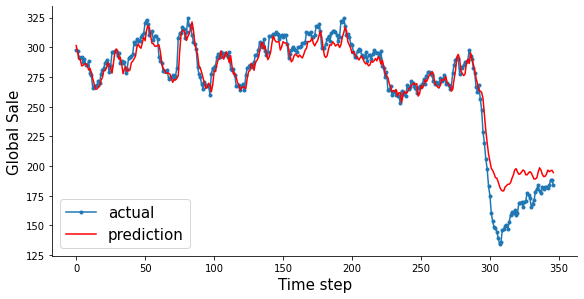

In [144]:
aa=[x for x in range(347)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test_Sca[0][:347], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:347], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global Sale', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();